In [ ]:
transcript_directory = "./preprocessing/text/Transcript" # directory containing all the transcript csv files
label_filepath = "./preprocessing/label.csv" # file containing all the participants' label

In [26]:
import pandas as pd 
import os

In [27]:
eg_transcript_filepath = transcript_directory + "/301_TRANSCRIPT.csv" #insert file path to transcript here 
eg_transcript_filename = os.path.basename(eg_transcript_filepath)

df_transcript = pd.read_csv(eg_transcript_filepath, sep = '\t')
df_transcript.head()

,start_time,stop_time,speaker,value
0,29.428,35.888,Ellie,hi i'm ellie thanks for coming in today i was ...
1,32.738,33.068,Participant,thank you
2,36.598,40.948,Ellie,think of me as a friend i don't judge i can't ...
3,42.088,42.518,Participant,mmm k
4,42.358,51.738,Ellie,i'm here to learn about people and would love ...


In [28]:
df_labels = pd.read_csv(label_filepath)
df_labels.head()

,Participant_ID,label
0,301,0
1,302,0
2,303,0
3,304,0
4,305,0


In [29]:
def get_transcript(filepath):
    filename = os.path.basename(filepath)
    participant_no = int(filename[0:3])
    
    df_transcript = pd.read_csv(filepath, sep = '\t')  
    
    df_dropped_columns = df_transcript.drop(['start_time', 'stop_time'], axis = 1) # drop first 2 columns
    df_dropped_ellie = df_dropped_columns.set_index('speaker').drop(index = ['Ellie']) # drop anything Ellie says, she's not important
    df_cleaned = df_dropped_ellie.reset_index() 
    
    transcript_concat = '' 

    for index, row in df_cleaned.iterrows():
        if (index == 0):
            transcript_concat += str(row['value'])
        else:
            transcript_concat += ' ' + str(row['value'])
            
    return participant_no, transcript_concat

In [30]:
# Verify that we can get the right participant number and concatenated transcript

get_transcript(eg_transcript_filepath)

(301,
 "thank you mmm k i'm doing good thank you i'm from los angeles oh great i live in west los angeles the west side it's alright i xxx no i live alone so i love it i'm from here so i grew up here it's natural the weather um well the weather it's always good it's never it's never bad uh um there's always something to do it's rarely a dull moment the traffic the traffic is horrible well probably traffic is horrible in almost any major city but i hate the traffic not really i mean i have enough things going on here so if i travel it's usually somewhere that's within driving distance i studied uh business i did no i've i've been done for a few years so i haven't gone to school for a while one of these days i'll go back to graduate school but my dream job would be to just work for myself and making lots of money um i don't know i don't really have a dream job just something that i can i can work under my own terms and get paid decently and and be in a creative creative environment um i 

In [ ]:
def combine_transcripts(directory, label_filepath):
    column_names_final = ["Participant_ID", "Transcript", "label"]
    df_final = pd.DataFrame(columns=column_names_final)
    
    csv_files = [pos_csv for pos_csv in os.listdir(directory) if pos_csv.endswith('.csv')]
    
    # Load the label file once to avoid reading it repeatedly
    df_labels = pd.read_csv(label_filepath, index_col="Participant_ID")
    df_labels.index = df_labels.index.astype(str).str.strip()  # Clean up index

    # Check if the 'label' column exists
    if "label" not in df_labels.columns:
        print("Error: 'label' column not found in the label file.")
        return df_final
    
    rows = []  
    
    for filename in csv_files:
        filepath = directory + '/' + filename
        
        # Extract participant ID and transcript
        participant_no, transcript_concat = get_transcript(filepath)
        participant_no = str(participant_no).strip()  
        
        # Check if participant ID is in labels
        if participant_no in df_labels.index:
            label = df_labels.loc[participant_no]["label"]

            new_row = {"Participant_ID": participant_no, "Transcript": transcript_concat, "label": label}
            rows.append(new_row)  
        else:
            print(f"Warning: Participant {participant_no} not found in label file.")
    
    # Create the DataFrame from the list of rows
    if rows:
        df_final = pd.DataFrame(rows)
    
    # Sort the DataFrame by Participant ID
    df_final = df_final.sort_values(by=['Participant_ID'], ascending=True).reset_index(drop=True)
    
    return df_final


In [32]:
df = combine_transcripts(transcript_directory, label_filepath).sort_values(by=['Participant_ID'], ascending=True)


In [ ]:
df.to_csv("./preprocessing/raw_compiled_transcripts.csv", index=False)

In [34]:
df = df.reset_index(drop=True)

In [35]:
df.head()

,Participant_ID,Transcript,label
0,301,thank you mmm k i'm doing good thank you i'm f...,0
1,302,i'm fine how about yourself i'm from los ange...,0
2,303,okay how 'bout yourself here in california yea...,0
3,304,i'm doing good um from los angeles california ...,0
4,305,i'm doing alright uh originally i'm from calif...,0


In [36]:
from nltk.corpus import stopwords

stop_words = list(stopwords.words('english'))

# depressed persons tend to use first-person pronouns more, and third-person pronouns less. these words might provide indication
excluded_pronouns = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll",
                    "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's",
                     'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves']

for pronoun in excluded_pronouns:
    stop_words.remove(pronoun)

In [37]:
from nltk.tokenize import TweetTokenizer
import contractions
import re as re
import string

def filter_text(text):
    
    text = re.sub('<[^<]+?>', '', text) # remove anything enclosed by tags e.g. <>
    text = re.sub('\[(.*?)\]', '', text) # remove anything enclosed by closed brackets i.e. []
    text = contractions.fix(text) # expands contractions e.g.'he's happy' -> 'he is happy'
    
    text = text.lower() # contractions will capitalize 'i'
    text = text.translate(str.maketrans("", "", string.punctuation)) # remove remaining punctuations e.g. apostrophe
    
    tokens = TweetTokenizer().tokenize(text) # use TweetTokenizer as transcripts contain informal texts
    
    filtered_sentence = [w for w in tokens if w not in stop_words]
    text = ' '.join(filtered_sentence)
    
    return text

In [ ]:
import pandas as pd

df = pd.read_csv('./preprocessing/raw_compiled_transcripts.csv')

In [39]:
# Compare first entry

original_text = df.Transcript[0]

df.Transcript = df.Transcript.apply(filter_text)
filtered_text = df.Transcript[0]

print(f"The original text is:\n{original_text}")
print("-------------------------------------------")
print(f"The filtered text is:\n{filtered_text}")

The original text is:
thank you mmm k i'm doing good thank you i'm from los angeles oh great i live in west los angeles the west side it's alright i xxx no i live alone so i love it i'm from here so i grew up here it's natural the weather um well the weather it's always good it's never it's never bad uh um there's always something to do it's rarely a dull moment the traffic the traffic is horrible well probably traffic is horrible in almost any major city but i hate the traffic not really i mean i have enough things going on here so if i travel it's usually somewhere that's within driving distance i studied uh business i did no i've i've been done for a few years so i haven't gone to school for a while one of these days i'll go back to graduate school but my dream job would be to just work for myself and making lots of money um i don't know i don't really have a dream job just something that i can i can work under my own terms and get paid decently and and be in a creative creative env

In [ ]:
df.to_csv("./preprocessing/clean_compiled_transcripts.csv", index=False)
df.head()

,Participant_ID,Transcript,label
0,301,thank you mmm k i good thank you i los angeles...,0
1,302,i fine yourself i los angeles california part ...,0
2,303,okay bout yourself california yeah oh well it ...,0
3,304,i good um los angeles california um cool weath...,0
4,305,i alright uh originally i california uh born g...,0


In [41]:
df.shape

(45, 3)

BATAs

In [42]:
all_participants = df['Participant_ID'].values

all_participants

array([301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313,
       314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 326, 327, 328,
       329, 330, 332, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353,
       354, 355, 356, 362, 367, 372], dtype=int64)

In [98]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [43]:
import matplotlib.pyplot as plt

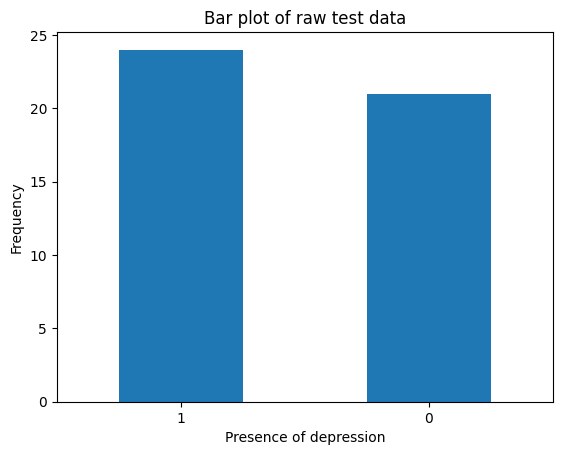

In [44]:
df_test = df[df.Participant_ID.isin(all_participants)]

df_test['label'].value_counts().plot(kind='bar', rot=0)
plt.ylabel("Frequency")
plt.xlabel("Presence of depression")
plt.title("Bar plot of raw test data")
plt.show()

In [45]:
import torch
from transformers import BertTokenizer, BertModel

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

In [ ]:
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    embedding = outputs.last_hidden_state[:, 0, :].detach().cpu().numpy().flatten()
    
    if embedding.shape[0] != 768:
        print(f"Warning: Unexpected embedding shape {embedding.shape} for text: {text[:50]}")
    
    return embedding

In [ ]:
def process_transcripts(input_csv, output_csv):
    df = pd.read_csv(input_csv)
    embeddings = []

    for _, row in df.iterrows():
        participant_id = row['Participant_ID']
        transcript = row['Transcript']
        
        print(f"Processing Participant {participant_id}...")
        embedding = get_bert_embedding(transcript)
        
        embeddings.append([participant_id] + embedding.tolist() + [row['label']])
    
    # Create column names (Participant_ID + 768 embedding dimensions + Label)
    column_names = ["Participant_ID"] + [f"BERT_{i}" for i in range(768)] + ["Label"]

    # Convert the embeddings list to a DataFrame with proper column names
    df_embeddings = pd.DataFrame(embeddings, columns=column_names)
    
    df_embeddings.to_csv(output_csv, index=False)

    print(f"Embeddings saved to {output_csv}")


In [ ]:
if __name__ == "__main__":
    input_csv = "./preprocessing/clean_compiled_transcripts.csv"
    output_csv = "./preprocessing/bert_embeddings.csv"
    
    process_transcripts(input_csv, output_csv)

    print("BERT feature extraction complete!")

Processing Participant 301...


Processing Participant 302...
Processing Participant 303...
Processing Participant 304...
Processing Participant 305...
Processing Participant 306...
Processing Participant 307...
Processing Participant 308...
Processing Participant 309...
Processing Participant 310...
Processing Participant 311...
Processing Participant 312...
Processing Participant 313...
Processing Participant 314...
Processing Participant 315...
Processing Participant 316...
Processing Participant 317...
Processing Participant 318...
Processing Participant 319...
Processing Participant 320...
Processing Participant 321...
Processing Participant 322...
Processing Participant 323...
Processing Participant 326...
Processing Participant 327...
Processing Participant 328...
Processing Participant 329...
Processing Participant 330...
Processing Participant 332...
Processing Participant 344...
Processing Participant 345...
Processing Participant 346...
Processing Participant 347...
Processing Participant 348...
Processing

In [ ]:
df = pd.read_csv("./preprocessing/bert_embeddings.csv")
print(df.shape)
print(df.head())

(45, 770)
   Participant_ID    BERT_0    BERT_1    BERT_2    BERT_3    BERT_4    BERT_5  \
0             301  0.425751  0.180377  0.363085  0.185841 -0.474959 -0.095134   
1             302  0.118533  0.064574  0.567143 -0.089609 -0.253438 -0.263409   
2             303  0.225767  0.316440  0.457851  0.111106 -0.086383  0.046190   
3             304  0.166075  0.171294  0.508915 -0.004415 -0.274525 -0.167221   
4             305  0.094837  0.266901  0.376740  0.002199 -0.324778 -0.004376   

     BERT_6    BERT_7    BERT_8  ...  BERT_759  BERT_760  BERT_761  BERT_762  \
0  0.012125  0.289598 -0.415915  ... -0.446853  0.089687  0.303306  0.379851   
1  0.131825  0.441377 -0.099779  ... -0.672680 -0.186279  0.126947  0.535741   
2  0.029571  0.212037 -0.356482  ... -0.521933 -0.232813  0.290403  0.430968   
3 -0.044383  0.344965 -0.426138  ... -0.414651 -0.258255  0.268923  0.476743   
4  0.119988  0.365760 -0.591842  ... -0.731170 -0.349641  0.155561  0.311118   

   BERT_763  BERT_764 